In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

def unzip_single_file(zip_path, output_folder):
    print(f"Extracting {zip_path} to {output_folder}...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(output_folder)
        print("Extraction complete.")
    except zipfile.BadZipFile:
        print(f"Bad ZIP file: {zip_path}")

# 경로 설정
train_image_root = "/content/drive/MyDrive/Project/image_data.zip"
train_output_dir = "/content/drive/MyDrive/Project/image_data"

# 폴더 존재 확인
if not os.path.exists(train_output_dir):
    os.makedirs(train_output_dir)

# ZIP 파일 압축 해제
unzip_single_file(train_image_root, train_output_dir)

Extracting /content/drive/MyDrive/Project/image_data.zip to /content/drive/MyDrive/Project/image_data...
Extraction complete.


In [3]:
import os
import numpy as np
from glob import glob

# 기존과 동일하게 seed 설정
np.random.seed(724)

# 수정해야 할 디렉토리 경로
dir_main = "/content/drive/MyDrive/Project/image_data"  # 실제 경로로 수정해주세요.

# 각 데이터셋에 대한 디렉토리 정의
dir_data_train = os.path.join(dir_main, 'train')
dir_data_valid = os.path.join(dir_main, 'valid')
dir_data_test = os.path.join(dir_main, 'test')

# 클래스 정보 수집
classes = glob(f"{dir_data_train}/*")  # 클래스는 train 폴더 내부에 정의되어 있다고 가정
class_info = {idx: os.path.basename(cls) for idx, cls in enumerate(classes)}

# 이미지 파일 경로 수집
img_files_train = glob(f"{dir_data_train}/*/*.jpg")
img_files_valid = glob(f"{dir_data_valid}/*/*.jpg")
img_files_test = glob(f"{dir_data_test}/*/*.jpg")

# NumPy 배열로 데이터 생성
dataset_train = np.array([[img_file, img_file.split("/")[-2]] for img_file in img_files_train])
dataset_valid = np.array([[img_file, img_file.split("/")[-2]] for img_file in img_files_valid])
dataset_test = np.array([[img_file, img_file.split("/")[-2]] for img_file in img_files_test])

# x, y 분리
x_train, y_train = dataset_train[:, 0], dataset_train[:, 1]
x_valid, y_valid = dataset_valid[:, 0], dataset_valid[:, 1]
x_test, y_test = dataset_test[:, 0], dataset_test[:, 1]

In [4]:
print(f"Classes: {classes}")
print(f"Train Files: {len(img_files_train)}")
print(f"Valid Files: {len(img_files_valid)}")
print(f"Test Files: {len(img_files_test)}")

Classes: ['/content/drive/MyDrive/Project/image_data/train/0', '/content/drive/MyDrive/Project/image_data/train/1', '/content/drive/MyDrive/Project/image_data/train/2', '/content/drive/MyDrive/Project/image_data/train/3', '/content/drive/MyDrive/Project/image_data/train/4', '/content/drive/MyDrive/Project/image_data/train/5', '/content/drive/MyDrive/Project/image_data/train/6']
Train Files: 32120
Valid Files: 8030
Test Files: 3124


In [5]:
def create_symlink(x_target, name='train'):
    for x in x_target:
        src = os.path.abspath(x)
        dst = src.replace("raw", name)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        if not os.path.exists(dst):
            os.symlink(src, dst)

create_symlink(x_train, "train")
create_symlink(x_test, "test")
create_symlink(x_valid, "val")

def get_numbers(ys, cls=None):
    cls_cnt = {}
    for y in ys:
        if y not in cls_cnt.keys():
            cls_cnt[y]=0
        cls_cnt[y]+=1
    if cls is None:
        return cls_cnt
    return cls_cnt[cls]

print(f"Class\t\tTrain\tVal\tTest\n")
for cls in class_info.values():
    print(f"{cls:10}\t{get_numbers(y_train, cls)}\t{get_numbers(y_valid, cls)}\t{get_numbers(y_test, cls)}")

Class		Train	Val	Test

0         	7186	1388	627
1         	9787	2465	845
2         	6463	1765	736
3         	4245	1114	435
4         	2151	654	354
5         	2108	580	94
6         	180	64	33


In [6]:
import os
import torch
import numpy as np
from PIL import Image
from glob import glob
from torch.utils.data import Dataset

class AgeClass(Dataset):
    def __init__(self, dir_dataset, tr):
        self.dir_dataset = os.path.abspath(dir_dataset)
        self.filelist = glob(self.dir_dataset + '/*/*.jpg')
        assert len(self.filelist) != 0, f"{self.dir_dataset + '/*/*.jpg'} is empty"
        self.classes = ['0', '1', '2', '3', '4', '5', '6']  # 클래스 이름을 숫자로 변경
        self.tr = tr

    def get_image(self, filename):
        img = Image.open(filename)
        img = self.tr(img)
        return img

    def get_label(self, filename):
        label = filename.split("/")[-2]  # 라벨을 디렉터리 이름에서 추출
        label = int(label)  # 라벨을 정수로 변환
        return torch.tensor(label, dtype=torch.long)

    def __getitem__(self, idx):
        filename = self.filelist[idx]
        img = self.get_image(filename)
        label = self.get_label(filename)
        return img, label

    def __len__(self):
        return len(self.filelist)

class DeviceDataLoader():
    def __init__(self, dl):
        self.dl = dl
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def to_device(self, data):
        if isinstance(data, (list, tuple)):
            return [self.to_device(x) for x in data]
        return data.to(self.device, non_blocking=True)

    def __iter__(self):
        for b in self.dl:
            yield self.to_device(b)

    def __len__(self):
        return len(self.dl)

In [14]:
## 라벨 확인
# from torchvision import transforms

# # transform 정의
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

# # AgeClass 인스턴스 생성
# dataset = AgeClass("/content/drive/MyDrive/Project/image_data/test", tr=transform)

# # 첫 번째 항목의 라벨 확인
# _, label = dataset[3100]
# print(label)

tensor(6)


In [15]:
from torch.utils.data import DataLoader
import torchvision.transforms as T

# print(model.default_cfg['mean']) # 'mean': (0.485, 0.456, 0.406)
# print(model.default_cfg['std']) # 'std': (0.229, 0.224, 0.225)
normalize = T.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

'''
Resize: 이미지 크기를 조정합니다.
CenterCrop: 이미지의 중앙 부분을 잘라냅니다.
RandomCrop: 이미지에서 무작위로 부분을 잘라냅니다.
RandomHorizontalFlip: 이미지를 수평 방향으로 무작위로 뒤집습니다.
RandomRotation: 이미지를 주어진 각도 범위 내에서 무작위로 회전시킵니다.
ToTensor: 이미지 데이터를 PyTorch 텐서로 변환합니다.
Normalize: 텐서를 주어진 평균 및 표준 편차 값으로 정규화합니다.
'''

train_tr = T.Compose([
    T.Resize((256, 256)),
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize
])

test_tr = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    normalize
])

train_ds = AgeClass(os.path.join(dir_main, "train"), train_tr)
val_ds = AgeClass(os.path.join(dir_main, "valid"), test_tr)
test_ds = AgeClass(os.path.join(dir_main, "test"), test_tr)

train_dl = DataLoader(train_ds, shuffle=True, num_workers=0, batch_size=64)
val_dl = DataLoader(val_ds, shuffle=True, num_workers=0, batch_size=64)
test_dl = DataLoader(test_ds, shuffle=True, num_workers=0, batch_size=64)

train_dl = DeviceDataLoader(train_dl)
val_dl = DeviceDataLoader(val_dl)
test_dl = DeviceDataLoader(test_dl)

In [17]:
# pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.1 MB/s eta 0:00:00


In [18]:
import timm

print(f"The number of pretrained models : {len(timm.list_models('*', pretrained=True))}")
timm.list_models('efficientnet*', pretrained=True)

The number of pretrained models : 1242


['efficientnet_b0.ra_in1k',
 'efficientnet_b1.ft_in1k',
 'efficientnet_b1_pruned.in1k',
 'efficientnet_b2.ra_in1k',
 'efficientnet_b2_pruned.in1k',
 'efficientnet_b3.ra2_in1k',
 'efficientnet_b3_pruned.in1k',
 'efficientnet_b4.ra2_in1k',
 'efficientnet_b5.sw_in12k',
 'efficientnet_b5.sw_in12k_ft_in1k',
 'efficientnet_el.ra_in1k',
 'efficientnet_el_pruned.in1k',
 'efficientnet_em.ra2_in1k',
 'efficientnet_es.ra_in1k',
 'efficientnet_es_pruned.in1k',
 'efficientnet_lite0.ra_in1k',
 'efficientnetv2_rw_m.agc_in1k',
 'efficientnetv2_rw_s.ra2_in1k',
 'efficientnetv2_rw_t.ra2_in1k']

In [19]:
model = timm.create_model('efficientnet_b0', pretrained=True)
model.default_cfg

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth',
 'hf_hub_id': 'timm/efficientnet_b0.ra_in1k',
 'architecture': 'efficientnet_b0',
 'tag': 'ra_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.875,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv_stem',
 'classifier': 'classifier'}

In [20]:
# check output dimension
print(model.global_pool)
print(model.get_classifier())

SelectAdaptivePool2d (pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
Linear(in_features=1280, out_features=1000, bias=True)


In [21]:
import torch
import torch.nn as nn
import timm

# to_device function
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Your classes
classes = ['0', '1', '2', '3', '4', '5', '6']

# device definition
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class EfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=len(classes), global_pool='avg')

    def forward(self, x):
        return torch.sigmoid(self.model(x))

# Initialize model
model = EfficientNet()

# Move model to device
model = to_device(model, device)

In [24]:
import pickle
import os
import torch.nn.functional as F


class TrainHelper():
    def __init__(self, save_path='./ckpt/history.pickle', history=[]):
        self.history = history
        self.save_path = save_path
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    def accuracy(self, outputs, labels):
        pred = torch.max(outputs, dim=1)[1]
        if len(labels.shape) > 1:
            gt = torch.argmax(labels, dim=1)
        else:
            gt = labels
            # gt = torch.max(labels, dim=1)[1]
        return torch.tensor(torch.sum(pred == gt).item() / len(pred))

    @torch.no_grad()
    def validation(self, batch):
        images, labels = batch
        out = model(images)
        acc = self.accuracy(out, labels)
        loss = F.cross_entropy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    @torch.no_grad()
    def evaluation(self, model, data_loader):
        model.eval()
        outputs = [self.validation(batch) for batch in data_loader]
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': round(epoch_loss.item(), 5), 'val_acc': round(epoch_acc.item(), 5)}

    def logging(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        self.history.append(result)
        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

train_helper = TrainHelper()

In [25]:
train_helper.evaluation(model, val_dl)

{'val_loss': 2.00924, 'val_acc': 0.13538}

In [26]:
from tqdm import tqdm

epochs = 2
optimizer = torch.optim.Adam(model.parameters(), 5.5e-5)
val_acc_best = 0
save_model_path = "/content/drive/MyDrive/Project/"
os.makedirs(save_model_path, exist_ok=True)
for epoch in range(epochs):
    # Training Phase
    model.train()
    train_losses = []
    for batch in tqdm(train_dl):
        inputs, targets = batch
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, targets)

        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation phase
    result = train_helper.evaluation(model, val_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()

    # Save the best model
    if result['val_acc'] >= val_acc_best:
        val_acc_best = result['val_acc']
        if 'save_model_name' in locals() and os.path.exists(save_model_name):
            os.remove(save_model_name)
        save_model_name = os.path.join(save_model_path, f"best_ep_{epoch}_{val_acc_best}.pt")
        torch.save(model.state_dict(), save_model_name)
        print(f"Saved PyTorch Model State to {save_model_name}")

    train_helper.logging(epoch, result)

# Save the last model
save_model_name = os.path.join(save_model_path, f"last_ep_{epoch}_{val_acc_best}.pt")
torch.save(model.state_dict(), save_model_name)

100%|██████████| 502/502 [02:57<00:00,  2.83it/s]


Saved PyTorch Model State to ./ckpt/best_ep_0_0.51904.pt
Epoch 0: train_loss: 1.5765, val_loss: 1.5255, val_acc: 0.5190


100%|██████████| 502/502 [02:45<00:00,  3.03it/s]


Saved PyTorch Model State to ./ckpt/best_ep_1_0.54409.pt
Epoch 1: train_loss: 1.4577, val_loss: 1.4924, val_acc: 0.5441


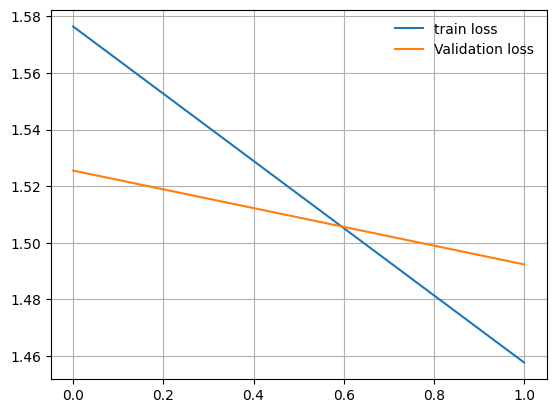

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

train_loss = [history['train_loss'] for history in train_helper.history]
val_loss = [history['val_loss'] for history in train_helper.history]

plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='Validation loss')
plt.grid()
plt.legend(frameon=False)

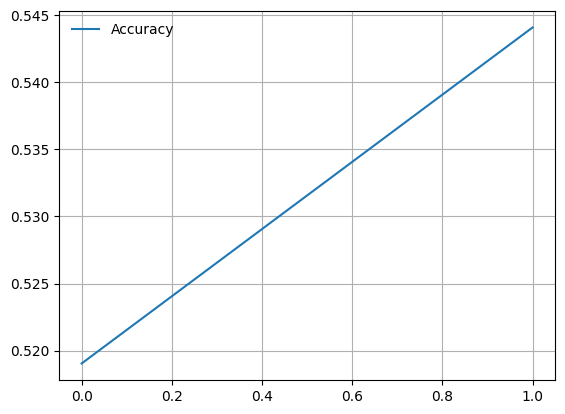

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

val_acc = [history['val_acc'] for history in train_helper.history]
plt.plot(val_acc, label='Accuracy')
plt.grid()
plt.legend(frameon=False)

100%|██████████| 49/49 [00:13<00:00,  3.51it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classes : ['0', '1', '2', '3', '4', '5', '6']
Performance 
              precision    recall  f1-score   support

           0      0.851     0.737     0.790       627
           1      0.541     0.641     0.587       845
           2      0.485     0.447     0.465       736
           3      0.323     0.572     0.413       435
           4      0.410     0.090     0.148       354
           5      0.385     0.213     0.274        94
           6      0.000     0.000     0.000        33

    accuracy                          0.523      3124
   macro avg      0.428     0.386     0.382      3124
weighted avg      0.534     0.523     0.509      3124



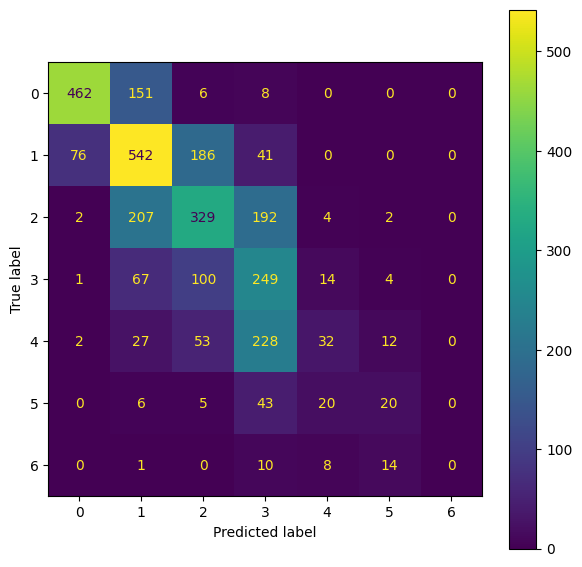

In [31]:
from sklearn import metrics
import matplotlib.pyplot as plt

model.eval()

y_pred = []
y_true = []
for batch in tqdm(test_dl):
    inputs, targets = batch
    outputs = model(inputs)
    # y_pred.extend(torch.max(outputs, dim=1)[1].numpy())
    # y_true.extend(torch.max(targets, dim=1)[1].numpy())
    y_pred.extend(torch.max(outputs, dim=1)[1].cpu().numpy())
    # y_true.extend(torch.max(targets, dim=1)[1].cpu().numpy())
    y_true.extend(targets.cpu().numpy())  # torch.max 사용 없이


performance = metrics.classification_report(y_true, y_pred, digits=3)
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

classes = test_ds.classes
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(range(len(classes))))
print(f"Classes : {classes}")
print(f"Performance \n{performance}")

disp.plot()
fig = disp.ax_.get_figure()
fig.set_figwidth(len(classes))
fig.set_figheight(len(classes))
plt.savefig("/content/drive/MyDrive/Project/confusion_matrix.jpg")
plt.show()

In [33]:
import torch

model=EfficientNet()
model.load_state_dict(torch.load("/content/ckpt/best_ep_1_0.54409.pt", map_location='cpu'))

<All keys matched successfully>

In [34]:
# Recovery of normalized image dataset for visualization
normalize_inverted = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [36]:
from IPython.display import display
from PIL import Image
FP = 3
for data in test_dl:
    if FP==0:
        break
    img_batch, label_batch = data
    results = model(img_batch)
    confs, preds = torch.max(results, dim=1)
    _, gts = torch.max(label_batch, dim=1)
    preds = preds.numpy()
    confs = confs.detach().numpy()
    gts = gts.numpy()

    for img, p, conf, g in zip(img_batch, preds, confs, gts):
        if FP <= 0:
            break
        x = normalize_inverted(img).numpy()
        x = (x * 255).astype(np.uint8).T
        x = Image.fromarray(x)
        if p!=g:
            display(x)
            print(f"Prediction   : {test_ds.classes[p]} ({conf:0.4f})")
            print(f"Ground Truth : {test_ds.classes[g]}")
            FP -= 1


RuntimeError: ignored